# Processing of DOU masks

In [5]:
import nibabel as nib
import nilearn as nil
import numpy as np 
import sys
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist

import cmbnet.preprocessing.mask_process as utils_process
from cmbnet.preprocessing.datasets.dou import load_DOU_raw, process_DOU_anno
import cmbnet.visualization.utils_plotting as utils_plt
import os
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt


In [6]:
subject = "16"
input_dir = "/home/cerebriu/data/datasets/raw/DOU/"

sequences_raw, labels_raw, sequence_type, centersofmass = load_DOU_raw(input_dir, subject)

In [7]:
centersofmass

[(188, 196, 39),
 (210, 188, 47),
 (76, 242, 60),
 (122, 218, 61),
 (117, 271, 64),
 (214, 183, 65),
 (54, 194, 67),
 (292, 179, 72),
 (240, 230, 80),
 (258, 120, 103),
 (263, 220, 114)]

In [8]:
# comss =centersofmass
comms = [(117, 271, 64)]
# comms=centersofmass
mri_im = sequences_raw['SWI']
mri_data = mri_im.get_fdata()

labels_procesed, metadata, msg = process_DOU_anno( mri_im, comms , "")

(117, 271, 64)


Looping over tolerances:   0%|          | 6/2000 [00:49<4:32:04,  8.19s/it]


In [9]:
# mri_im = sequences_raw['SWI']
# mri_data = mri_im.get_fdata()
# cmb_conflictive = (117, 271, 64)
# print(f"--{cmb_conflictive}--: {mri_data[cmb_conflictive]} ORIGINAL")

# x, y, z = cmb_conflictive
# offset_range = 1  # To specifically inspect the 26 neighbors around the original point

# for dx in range(-offset_range, offset_range + 1):
#     for dy in range(-offset_range, offset_range + 1):
#         for dz in range(-offset_range, offset_range + 1):
#             if dx == 0 and dy == 0 and dz == 0:
#                 continue  # Skip the original voxel itself
#             new_coord = (x + dx, y + dy, z + dz)
#             if (0 <= new_coord[0] < mri_data.shape[0]) and (0 <= new_coord[1] < mri_data.shape[1]) and (0 <= new_coord[2] < mri_data.shape[2]):
#                 relative_difference = abs((mri_data[new_coord] - mri_data[cmb_conflictive]) / mri_data[cmb_conflictive] ) if mri_data[cmb_conflictive] != 0 else "Undefined"
#                 print(f"\t{new_coord} (offsets: dx={dx}, dy={dy}, dz={dz}): {mri_data[new_coord]} ----- Relative Difference: {relative_difference}")
#             else:
#                 print(f"\t{new_coord} (offsets: dx={dx}, dy={dy}, dz={dz}): Out of bounds")


In [10]:
metadata

[{'n_pixels': 344,
  'tolerance_selected': 0.75,
  'tolerance_pixel_counts': [1,
   1,
   3,
   6,
   6,
   7,
   8,
   12,
   12,
   126,
   153,
   176,
   183,
   197,
   215,
   304,
   2595],
  'tolerances_inspected': 17,
  'elbow_i': 15}]

In [11]:
print(msg)

		Maximum distance allowed (voxels)=15 Size threshold=2594.
		Processing CMB annotations 
		Finished processing CMB 0. com=(117, 271, 64), new_size=338



In [12]:
def apply_2D_zoom(image, zoom_coords, zoom_size):
    if zoom_coords and zoom_size:
        x_center, y_center = zoom_coords
        half_size = zoom_size // 2

        # Ensure the zoom region doesn't exceed the image dimensions
        x_start = max(x_center - half_size, 0)
        y_start = max(y_center - half_size, 0)
        x_end = min(x_center + half_size, image.shape[1])
        y_end = min(y_center + half_size, image.shape[0])

        newim = image[y_start:y_end, x_start:x_end]
        return newim
    return image

def adjust_for_radiological_view(image: np.ndarray) -> np.ndarray:
    """
    Adjusts the image for the radiological view by rotating it 90 degrees clockwise.
    """
    return np.rot90(image)

def plot_cross_with_gap(ax, x, y, width, height, color='r', gap_size=5, line_length=10, **kwargs):
    """
    Draws a cross on the plot with a specified gap around the center, accounting for y-axis inversion.

    Args:
        ax: The axis on which to draw.
        x, y: The center coordinates of the cross, considering y-axis inversion.
        width, height: The width and height of the plotting area, used for y-axis inversion.
        color: The color of the cross.
        gap_size: The size of the gap around the center.
        line_length: The length of each line of the cross.
    """
    # Invert y-coordinate for plotting, assuming y increases downwards
    inverted_y = height - y

    # Vertical line (adjustment only needed for y-axis inversion)
    ax.plot([x, x], [inverted_y - gap_size - line_length, inverted_y - gap_size], color=color, **kwargs)
    ax.plot([x, x], [inverted_y + gap_size, inverted_y + gap_size + line_length], color=color, **kwargs)
    
    # Horizontal line
    ax.plot([x - gap_size - line_length, x - gap_size], [inverted_y, inverted_y], color=color, **kwargs)
    ax.plot([x + gap_size, x + gap_size + line_length], [inverted_y, inverted_y], color=color, **kwargs)


def plot_processed_mask(mri_data, cmb_data, out_mask, cmb_coords, seq_type, zoom_coords=None, zoom_size=None):
    assert len(cmb_coords) == 3
    if zoom_coords is None:
        zoom_coords = cmb_coords[:2]

    fig, axs = plt.subplots(1, 2, figsize=(8, 10))

    zoomed_mri = adjust_for_radiological_view(apply_2D_zoom(mri_data[:, :, cmb_coords[-1]], zoom_coords, zoom_size))
    zoomed_mask = adjust_for_radiological_view(apply_2D_zoom(cmb_data[:, :, cmb_coords[-1]], zoom_coords, zoom_size))
    zoomed_generated_mask = adjust_for_radiological_view(apply_2D_zoom(out_mask[:, :, cmb_coords[-1]], zoom_coords, zoom_size))

    # Calculate the relative position after rotation
    if zoom_size is not None:
        rel_x = cmb_coords[0] - zoom_coords[0] + zoom_size // 2
        rel_y = cmb_coords[1] - zoom_coords[1] + zoom_size // 2
    else:
        rel_x, rel_y = cmb_coords[:2]

    width, height = zoomed_mask.shape[1], zoomed_mask.shape[0]  # Dimensions after zoom and before rotation

    # Original Annotation Overlay
    axs[0].imshow((zoomed_mri), cmap='gray')
    axs[0].imshow(zoomed_mask, alpha=0.5, cmap="Reds")
    axs[0].set_title('Original Mask')
    plot_cross_with_gap(axs[0], rel_x, rel_y, width, height, line_length=25, gap_size=10, linewidth=1)
    axs[0].axis('off')
    
    # Generated Mask Overlay
    axs[ 1].imshow((zoomed_mri), cmap='gray')
    axs[ 1].imshow((zoomed_generated_mask), alpha=0.5, cmap="Reds")
    plot_cross_with_gap(axs[1], rel_x, rel_y, width, height, line_length=25, gap_size=10, linewidth=1)
    axs[ 1].set_title('Generated Mask')
    axs[ 1].axis('off')

    plt.tight_layout()
    plt.show()

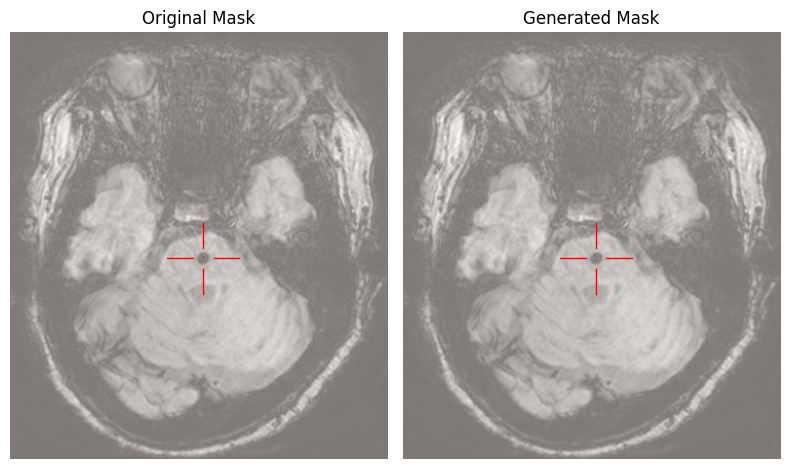

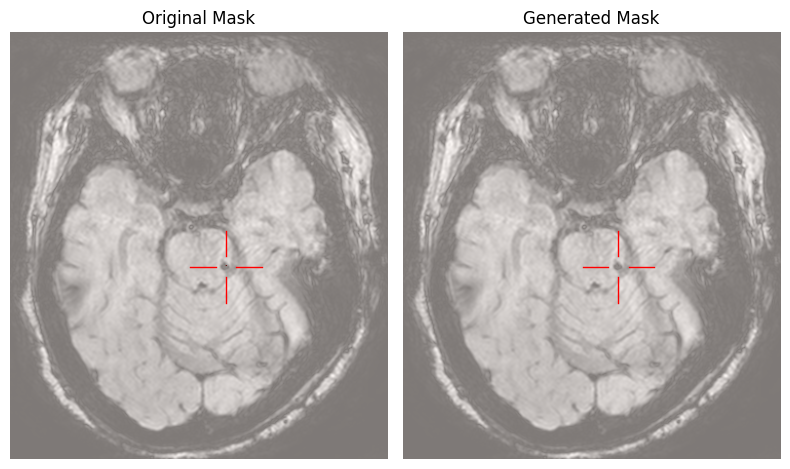

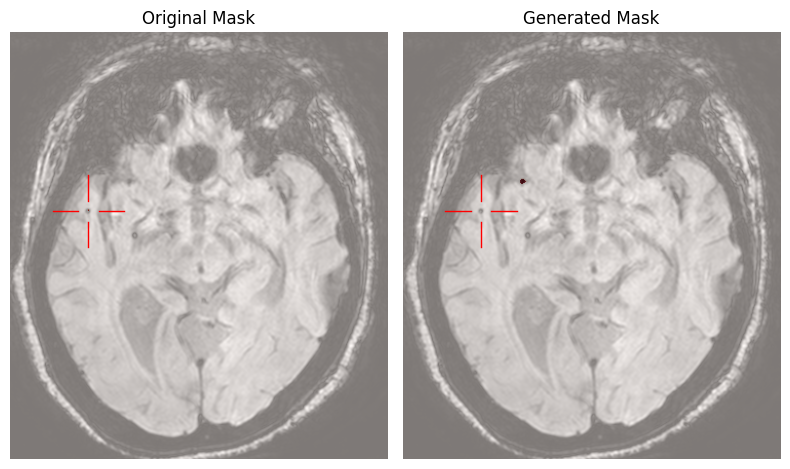

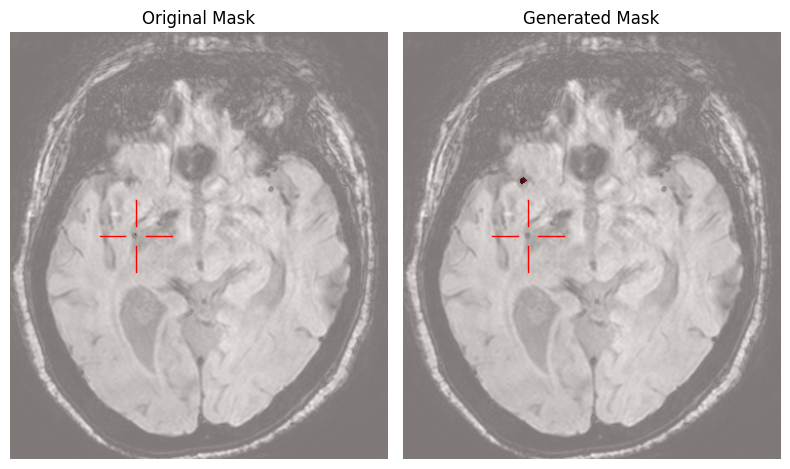

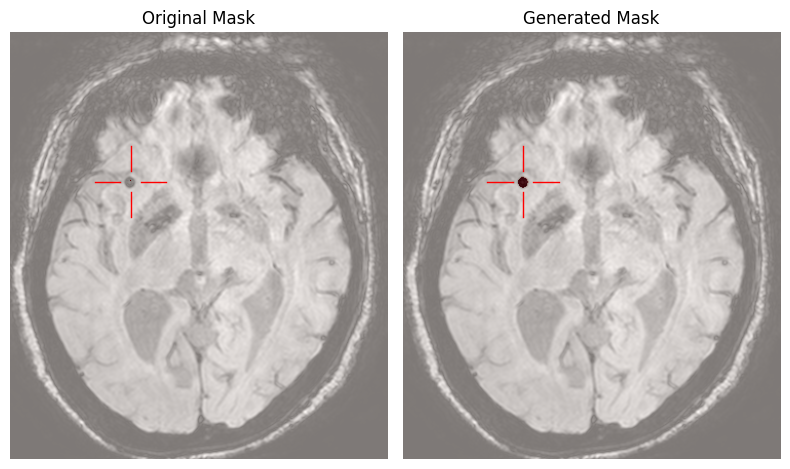

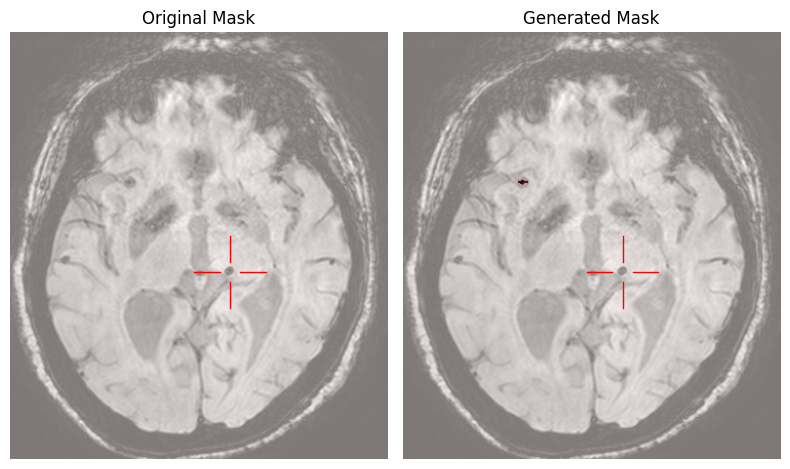

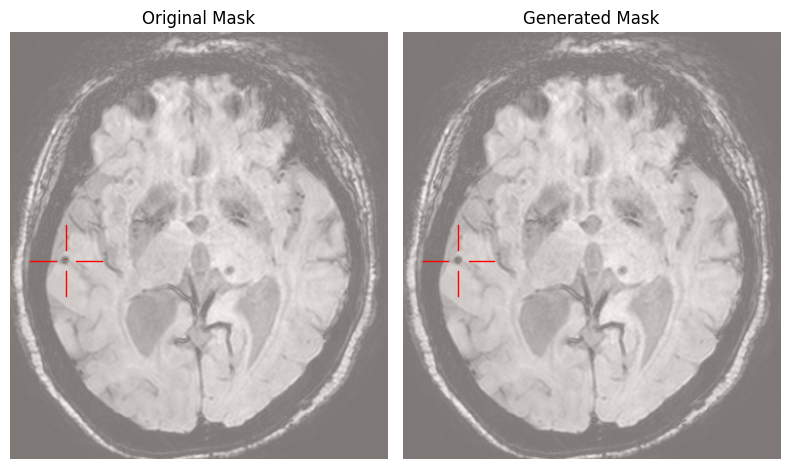

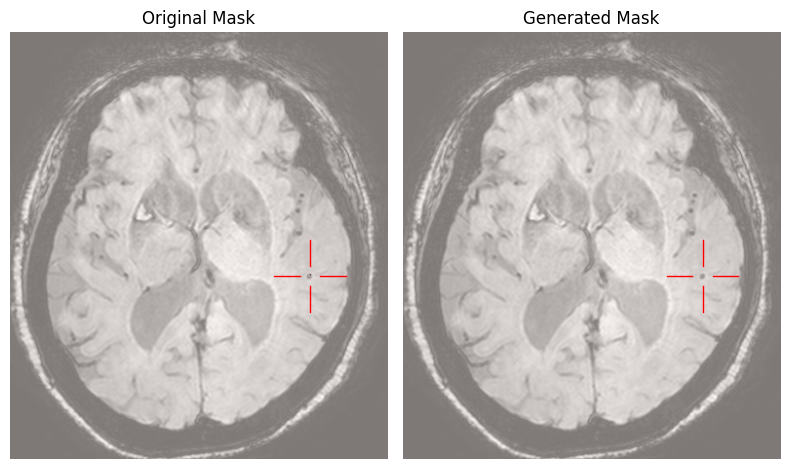

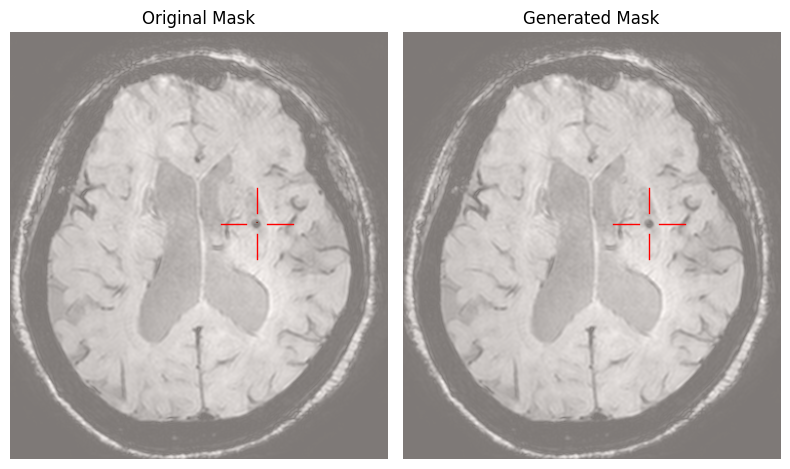

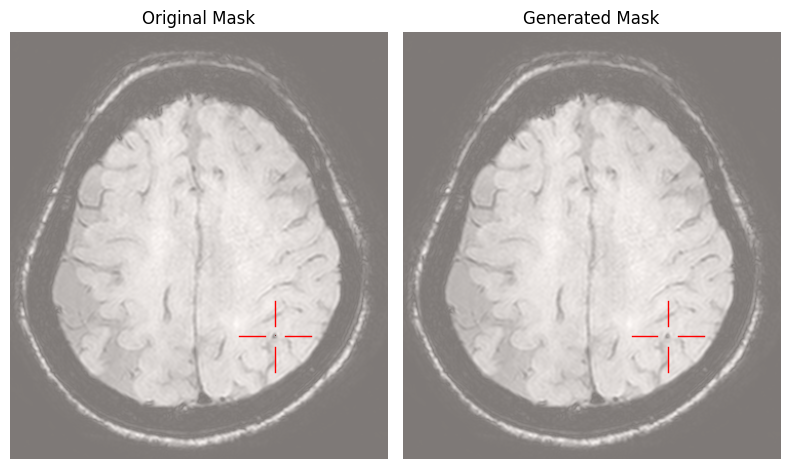

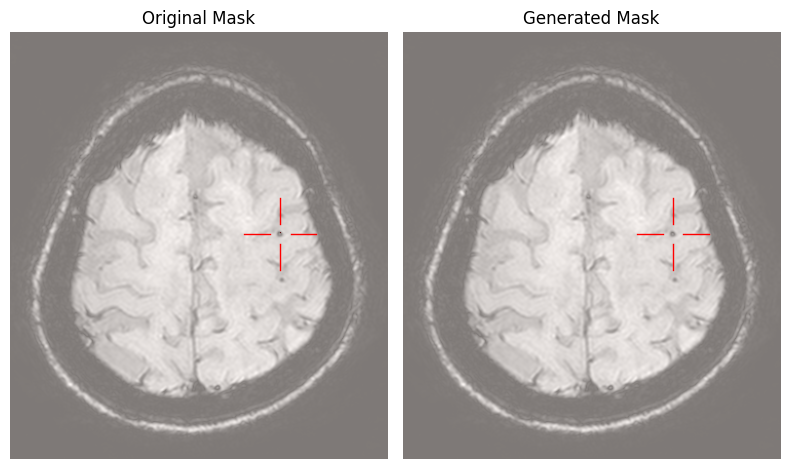

In [13]:
im1 = sequences_raw['SWI'].get_fdata()
cmb1 = labels_raw['SWI'].get_fdata()

# Create a mask of the same size as the image, initialized to zero
mask = np.zeros_like(im1)

for i, CM in enumerate(centersofmass):
    # if CM != (117, 271, 64):
    #     continue
    # print(CM)
    plot_processed_mask(
        im1, cmb1, labels_procesed.get_fdata(), CM, "SWI"
    )